In [1]:
#simulations infrastructure
import splat
import wisps.simulations as wispsim
from wisps.utils.tools import distance
from astropy.coordinates import SkyCoord

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd

import seaborn as sns
%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spe
import splat.simulate as spsim
import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [6.0, 3.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

from astropy import stats as astrostats

In [2]:
def fit_polynomial(x, y, n=2):
    #sigma clipping
    scatter=np.nanstd(y)
    index=np.where((y<3.0*scatter) | (y>3.0*scatter))[0]
    p = np.poly1d(np.polyfit(x[index], y[index], n))
    return p

def dropnans(x):
    return [~np.isnan(x)]

### Generate a spectral type, HST mags relation <br>
Using spex templates/standards


In [3]:
spe.typeToMag('L0','2MASS J',set='dupuy')

(11.618345999999997, 0.4)

In [4]:
splat.initializeStandards()

In [5]:
def absolute_mag_dupuy(spt, filt):
    #use the uncertainty in dupuy relation 
    val, unc=spe.typeToMag(splat.typeToNum(spt),filt,set='dupuy')
    return np.random.normal(val, unc)

In [6]:
#1.visualize dupuy relation
sp_grid=np.arange(15, 38)
js = [absolute_mag_dupuy(x, '2MASS J') for x in sp_grid]
hs= [absolute_mag_dupuy(x, '2MASS H') for x in sp_grid]

In [7]:
#transform dupuy relation into HST mags
def get_colors(spt, flt):
    #using splat filtermag
    sp = splat.STDS_DWARF_SPEX[spt]
    sp.fluxCalibrate('2MASS J',float(sp.j_2mass))
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    magj, mag_uncj = splat.filterMag(sp,'2MASS J')
    magh, mag_unch = splat.filterMag(sp,'2MASS H')
    #calculate the offset between HST filters and 2mass filters but add the uncertainty
    
    magjtouse=np.random.normal(magj,  mag_uncj)
    maghtouse=np.random.normal(magh,  mag_unch)
    offsetj=magjtouse-mag
    offseth=maghtouse-mag
    return [offsetj, offseth]

In [8]:
def get_abs_hst_mag(color, mag0):
    return mag0-color

In [9]:
colors=[]
absmags=[]
fltrs= ['NICMOS {}'.format(k) for k in ['F110W', 'F140W', 'F160W']]
for x in tqdm(sp_grid):
    c=[]
    for flt in fltrs:
        color=get_colors(splat.typeToNum(x), flt)
        c.append(color)
    colors.append(c)
#abs_hstmags=[get_abs_hst_mag(splat.typeToNum(x)) for x in  sp_grid]

100%|██████████| 23/23 [00:23<00:00,  1.15s/it]


In [10]:
colors=np.array(colors)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


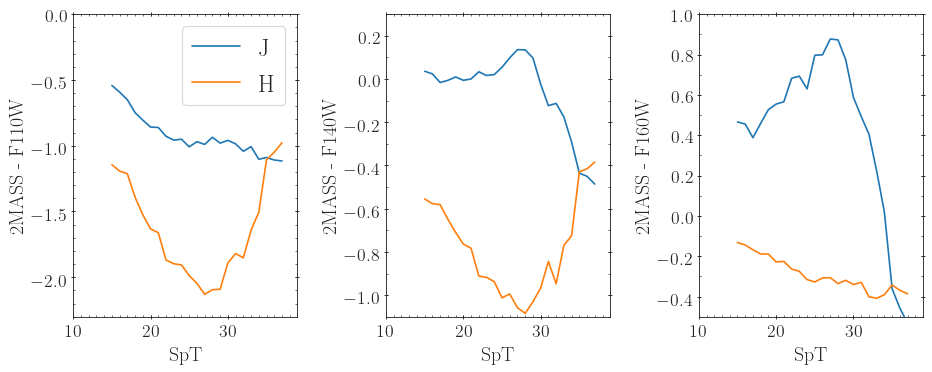

In [11]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 5), sharey=False)
for a in ax:
    a.set_xlabel('SpT')

ax[0].set_ylabel('2MASS - F110W')
ax[0].plot(sp_grid, colors[:,0][:,0], label='J')
ax[0].plot(sp_grid, colors[:,0][:,1], label='H')

ax[1].set_ylabel('2MASS - F140W')
ax[1].plot(sp_grid, colors[:,1][:,0], label='J')
ax[1].plot(sp_grid, colors[:,1][:,1], label='H')

ax[2].set_ylabel('2MASS - F160W')
ax[2].plot(sp_grid, colors[:,2][:,0], label='J')
ax[2].plot(sp_grid, colors[:,2][:,1], label='H')

ax[0].legend()

for a in ax:
    a.set_xticks(np.arange(10, 40, 1), minor=True)
    a.set_yticks(np.arange(-3, 1.0, 0.1), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_ylim([-2.3, 0.0])
ax[1].set_ylim([-1.1, 0.3])
ax[2].set_ylim([-0.5, 1.0])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mass_hubble_colors.pdf')

### Generate apparent HST mags<br>
Using candidates?

In [12]:
abs_hstmagsj=np.array([np.array(js)-x for x  in colors[:, :,0].T]).T
abs_hstmagsh=np.array([np.array(hs)-x for x  in colors[:, :,0].T]).T

In [13]:
def get_app_hst_mag(dist, absmag):
    ##returns apparent HST mag given distance and absolute mag
    return np.log10(dist-1)*5+absmag

In [14]:
#app_hstmags=[]
#for m in np.array(abs_hstmags)[:,:, 0]:
#    app_hstmags.append([get_app_hst_mag(ds, x) for x in  m])

In [15]:
avg_f110=np.nanmean([abs_hstmagsj[:,0], abs_hstmagsh[:,0]], axis=0)
avg_f140=np.nanmean([abs_hstmagsj[:,1], abs_hstmagsh[:,2]], axis=0)
avg_f160=np.nanmean([abs_hstmagsj[:,2], abs_hstmagsh[:,2]], axis=0)

In [16]:
abs_hstmags=np.array([avg_f110, avg_f140, avg_f160])

#app_hstmags=[]
#for m in np.array(abs_hstmags):
#    app_hstmags.append([get_app_hst_mag(ds, x) for x in  m])

## Visualization

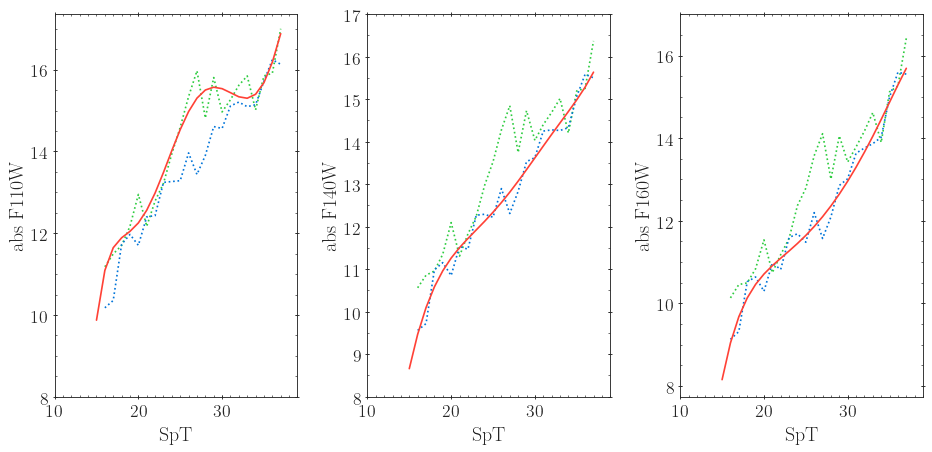

In [17]:
fig, ax=plt.subplots(ncols=3, sharey=False, figsize=(12, 6))
for a in ax:
    a.set_xlabel('SpT')

#ax[0].plot( sp_grid, np.array(js))
#ax[1].plot( sp_grid, np.array(hs))

#ax[0].set_ylabel('abs J')
#ax[1].set_ylabel('abs H')

ax[0].plot( sp_grid, abs_hstmagsj[:,0], c='#2ECC40', linestyle=':')
ax[1].plot( sp_grid, abs_hstmagsj[:,1], c='#2ECC40', linestyle=':')
ax[2].plot( sp_grid, abs_hstmagsj[:,2], c='#2ECC40', linestyle=':')

ax[0].plot( sp_grid, abs_hstmagsh[:,0],c='#0074D9', linestyle=':')
#ax[2].plot( sp_grid, avg_f110, linestyle='--', c='#111111')
ax[1].plot(sp_grid, abs_hstmagsh[:,1], c='#0074D9', linestyle=':')
#ax[3].plot( sp_grid, avg_f140, linestyle='--', c='#111111')
ax[2].plot( sp_grid, abs_hstmagsh[:,2], c='#0074D9', linestyle=':')
#ax[4].plot( sp_grid, avg_f160, linestyle='--', c='#111111')


ax[0].set_ylabel('abs F110W')
ax[1].set_ylabel('abs F140W')
ax[2].set_ylabel('abs F160W')


p4=fit_polynomial( sp_grid, abs_hstmagsj[:,0], n=6)
ax[0].plot( sp_grid, p4(sp_grid), c='#FF4136')


p5=fit_polynomial(sp_grid, abs_hstmagsh[:,1], n=6)
ax[1].plot( sp_grid, p5(sp_grid),c='#FF4136')

p6=fit_polynomial( sp_grid, abs_hstmagsh[:,2], n=6)
ax[2].plot( sp_grid, p6(sp_grid),  c='#FF4136')



for a in ax:
    a.set_xticks(np.arange(10, 40, 1), minor=True)
    a.set_yticks(np.arange(8, 17.5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/hst_relations.pdf')

In [18]:
#app_hstmags[:,2].shape

In [19]:
#fig, ax=plt.subplots(ncols=3, figsize=(12, 3), sharex=True)
#for a in ax:
#    a.invert_yaxis()
#    a.set_xscale('log')
#for i in np.arange(0, 18):
#    ax[0].plot(ds, np.array(app_hstmags)[:,i][0], color='#0074D9', alpha=0.4)
#    ax[1].plot(ds, np.array(app_hstmags)[:,i][1],  color='#0074D9', alpha=0.4)
#    ax[2].plot(ds, np.array(app_hstmags)[:,i][2],  color='#0074D9', alpha=0.4)

#ax[0].set_xlabel('distance (pc)')
#ax[1].set_xlabel('distance (pc)')
#ax[2].set_xlabel('distance (pc)')

#ax[0].set_ylabel('F110W')
#ax[1].set_ylabel('F140W')
#ax[2].set_ylabel('F160W')
#plt.tight_layout()

## Using my sample to map to SNR and sigma_error on app mags

In [20]:
cands=wisps.datasets['candidates']

In [21]:
#some reformatting
obs_F110W=np.array(np.apply_along_axis(list, 0,cands.F110.str.replace('nan', '-999').apply(eval).values))
obs_F140W=np.array(np.apply_along_axis(list, 0,cands.F140.str.replace('nan', '-999').apply(eval).values))
obs_F160W=np.array(np.apply_along_axis(list, 0,cands.F160.str.replace('nan', '-999').apply(eval).values))

In [22]:
obs_F160W[obs_F160W < -90.0]=np.nan
obs_F140W[obs_F140W < -90.0]=np.nan
obs_F110W[obs_F110W < -90.0]=np.nan

In [23]:
snrs=cands.snr1.values

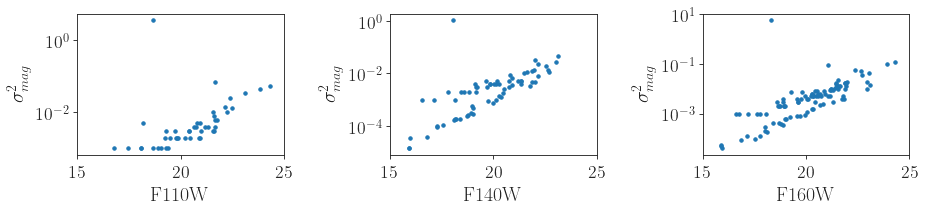

In [24]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 3))

mags=np.linspace(10, 27, 100)

for a in ax:
    #a.invert_yaxis()
    a.set_xlim([15, 25])
    a.set_ylabel(r'$\sigma^2_{mag}$')
    a.set_yscale('log')
ax[0].plot(obs_F110W[:,0], obs_F110W[:,1], '.')
ax[1].plot(obs_F140W[:,0], obs_F140W[:,1], '.')
ax[2].plot(obs_F160W[:,0], obs_F160W[:,1], '.')

ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')
plt.tight_layout()

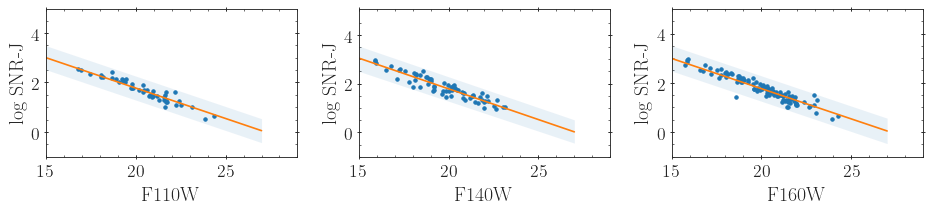

In [25]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 3))

for a in ax:
    a.set_ylabel(r'log SNR-J')
    a.set_xlim([15, 27])
    #a.set_ylim([0, 500])

ax[0].plot(obs_F110W[:,0], np.log10(snrs), '.')
ax[1].plot(obs_F140W[:,0], np.log10(snrs), '.')
ax[2].plot(obs_F160W[:,0], np.log10(snrs), '.')

nonnans110=dropnans(obs_F110W[:,0])
p0=fit_polynomial(obs_F110W[:,0][nonnans110], np.log10(snrs[nonnans110]), n=1)
ax[0].plot(mags, p0(mags))
ax[0].fill_between(mags, p0(mags)+np.std(np.log10(snrs[nonnans110])), p0(mags)-np.std(np.log10(snrs[nonnans110])), alpha=0.1 )

nonnans140=dropnans(obs_F140W[:,0])
p1=fit_polynomial(obs_F140W[:,0][nonnans140], np.log10(snrs[nonnans140]), n=1)
ax[1].plot(mags, p1(mags))
ax[1].fill_between(mags, p1(mags)+np.std(np.log10(snrs[nonnans140])), p0(mags)-np.std(np.log10(snrs[nonnans140])), alpha=0.1 )

nonnans160=dropnans(obs_F160W[:,0])
p2=fit_polynomial(obs_F160W[:,0][nonnans160], np.log10(snrs[nonnans160]), n=1)
ax[2].plot(mags, p2(mags))
ax[2].fill_between(mags, p2(mags)+np.std(np.log10(snrs[nonnans160])), p0(mags)-np.std(np.log10(snrs[nonnans160])), alpha=0.1 )

for a in ax:
    a.set_xticks(np.arange(15, 30, 1), minor=True)
    a.set_yticks(np.arange(-1, 5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_fits.pdf')

In [26]:
polrealtions={'snr_F110W':p0, 'snr_F140W':p1, 'snr_F160W':p2, \
             'sp_F110W':p4, 'sigma_log_f110':  np.std(np.log10(snrs[nonnans110])),
              'sigma_log_f140':  np.std(np.log10(snrs[nonnans140])),
              'sigma_log_f160':  np.std(np.log10(snrs[nonnans160])),
              'sp_F140W':p5, 'sp_F160W':p6}

In [27]:
import pickle
with open(wisps.OUTPUT_FILES+'/polynomial_relations.pkl', 'wb') as file:
    pickle.dump(polrealtions,file)

In [28]:
np.std(np.log10(snrs[nonnans110]))

0.483665666891304

In [29]:
print ('helllo world')

helllo world
